# Plots for npe

In [86]:
# magic command to reload modules
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from pathlib import Path
import sys
import yaml
from sbi import analysis
import os
from scipy.stats import gaussian_kde
from tqdm import tqdm

NSC_DIR = Path(os.getcwd()).resolve().parent.parent.as_posix()  # NSC dir
sys.path.append(f"{NSC_DIR}/codes/src")
from utils.setup import adapt_path
from utils.event import get_train_valid_lr
from utils.plots import load_img, pairplot, plot_posterior_mapped_samples, marginal_plot
from utils.inference import (
    get_posterior,
    load_stored_config,
    sampling_from_posterior,
    ci_perf_on_dset,
)
from utils.train import WarmupScheduler, plot_posterior_with_label, load_net, get_limits
from simulator.model_sim_pR import DM_sim_for_seqCs_parallel_with_smaller_output
from utils.range import x2seqC, seqC2x, convert_samples_range

import matplotlib as mpl
import matplotlib.pyplot as plt

# remove top and right axis from plots
mpl.rcParams["axes.spines.right"] = True
mpl.rcParams["axes.spines.top"] = True
# remove all edges
mpl.rcParams["axes.edgecolor"] = "k"
mpl.rcParams["axes.linewidth"] = 2
font = {
    "weight": "bold",
    "size": 22,
}
mpl.rc("font", **font)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


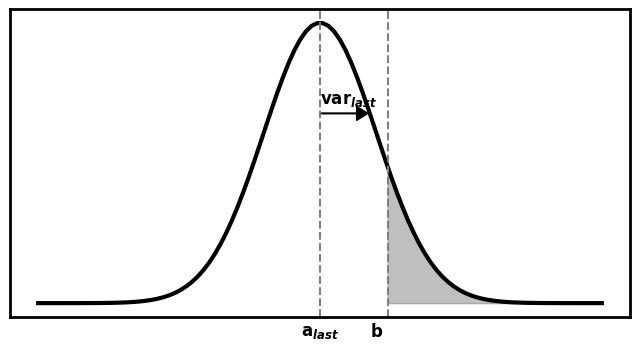

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

font = {
    "weight": "bold",
    "size": 12,
}
mpl.rc("font", **font)

mean = 0
var = 1
# Generate some data
np.random.seed(0)
data = np.random.randn(1000)

# Calculate the PDF over a range of values
x = np.linspace(-5, 5, 100)
y = norm.pdf(x, mean, var)  # mean=0, std=1

# Create a new figure and set the facecolor to none (transparent)
fig = plt.figure(facecolor="none", figsize=(8, 4))
ax = fig.add_subplot(111)

# Plot the Gaussian distribution curve
ax.plot(x, y, "k", linewidth=3)

# Draw a vertical line at x = 1
ax.axvline(x=1.2, color="gray", linestyle="--")
ax.axvline(x=0, color="gray", linestyle="--")

# Fill the area under the curve for x > 1
x_fill = np.linspace(1.2, 5, 100)
y_fill = norm.pdf(x_fill, mean, var)
ax.fill_between(x_fill, y_fill, color="gray", alpha=0.5)

# draw a bi-directional arrow from x=0 to x=1

# annotate the sigma values
ax.annotate(
    "$\mathbf{var}_{last}$",
    xy=(0.5, 0.1),
    xytext=(0, 0.285),
)
ax.arrow(0, 0.27, 0.65, 0, head_width=0.02, head_length=0.2, fc="k", ec="k")


# Remove the background
ax.set_facecolor("none")
# remove the ticks
ax.tick_params(axis="both", which="both", length=0)
# set x=0 with x tick label a
ax.set_xticks([0, 1])
ax.set_xticklabels(["$\mathbf{a}_{last}$", "b"])

# Hide the axis labels and grid
ax.set_yticklabels([])
ax.grid(False)

# Show the plot
plt.show()

## load data

In [12]:
# %% ==================================================
pipeline_version = "p5a"
train_id = "train_L0_p5a"
exp_id = "p5a-conv_lstm-corr_conv-tmp-2"

# %% ========== load the latest event file
log_dir = Path(NSC_DIR) / "codes/src/train/logs" / train_id / exp_id
(
    wall_time,
    step_nums,
    learning_rates,
    log_probs_train,
    log_probs_valid,
) = get_train_valid_lr(log_dir)

all_probs = np.concatenate([log_probs_train, log_probs_valid])
upper = np.max(all_probs)
lower = np.percentile(all_probs, 10)

# %% ========== load the config.yaml file
config_file = log_dir / "config.yaml"
config = adapt_path(config_file)

with open(config, "r") as f:
    config = yaml.safe_load(f)

prior_min = config["prior"]["prior_min"]
prior_max = config["prior"]["prior_max"]
# prior_labels = config["prior"]["prior_labels"]
prior_labels = ["$b$", "$\sigma^2_a$", "$\sigma^2_s$", "$\lambda$"]

{'images': [], 'audio': [], 'histograms': [], 'scalars': ['train_loss_batch', 'learning_rates'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['log_probs'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['log_probs'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}


## Training curve

Text(0.5, 0, 'time (hours)')

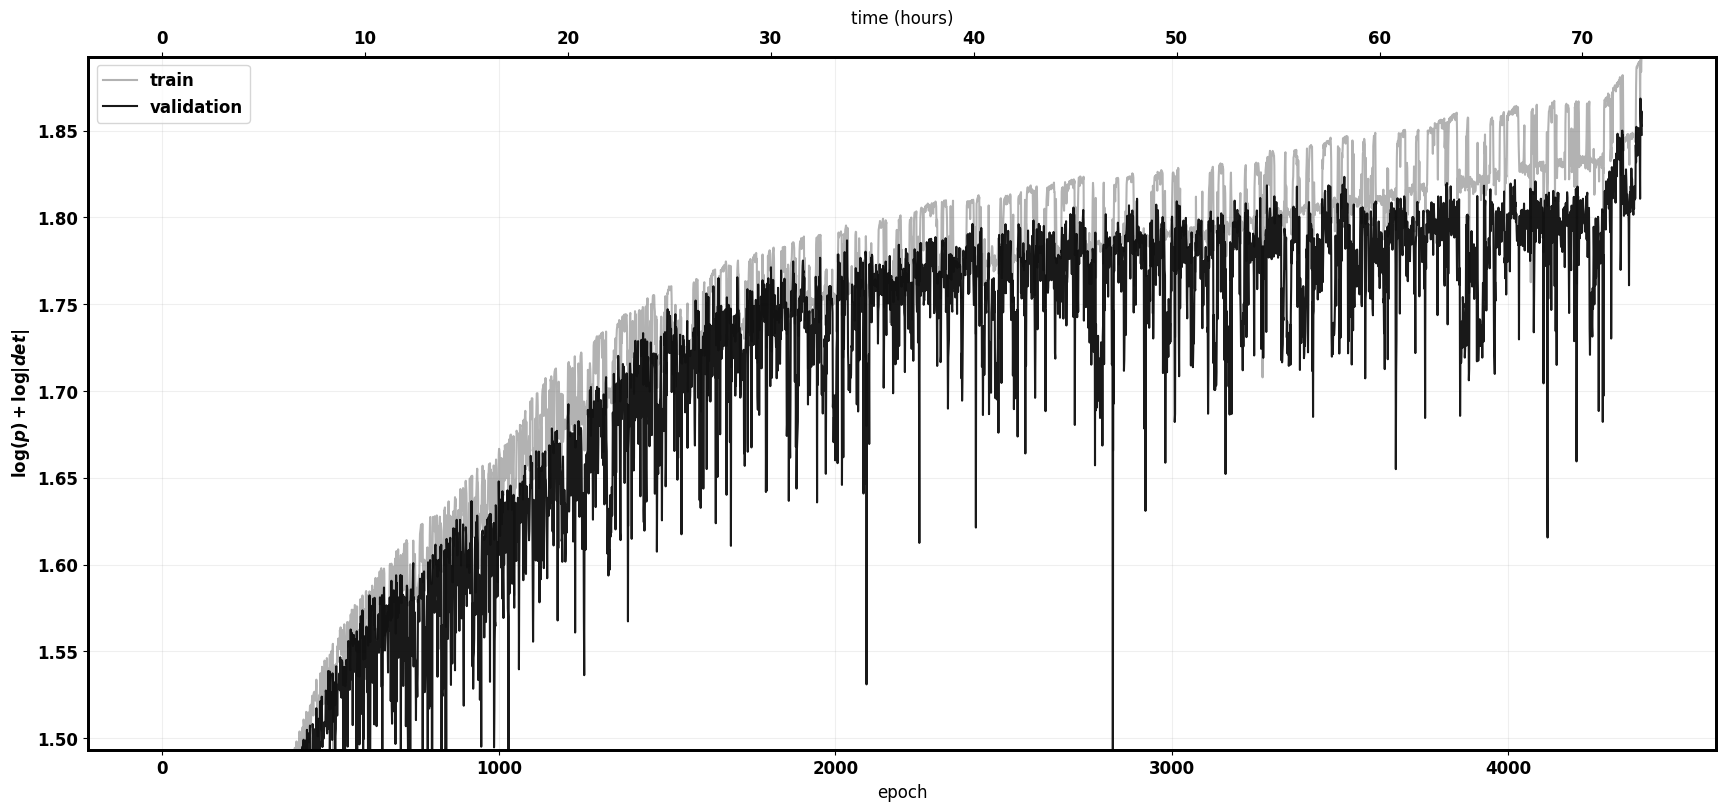

In [13]:
# %% ========== plot training curves
fig, ax = plt.subplots(figsize=(21, 9))
ax.plot(step_nums, log_probs_train, label="train", alpha=0.6, ms=0.2, color="tab:gray")
ax.plot(step_nums, log_probs_valid, label="validation", alpha=0.9, ms=0.2, color="k")
ax.set_ylim(lower, upper)
ax.set_xlabel("epoch")
ax.set_ylabel("$\log(p)+\log|det|$")
ax.grid(alpha=0.2)
ax.legend()

ax1 = ax.twiny()
ax1.plot(
    (np.array(wall_time) - wall_time[0]) / 60 / 60,
    max(log_probs_valid) * np.ones_like(log_probs_valid),
    "-",
    alpha=0,
)
ax1.set_xlabel("time (hours)")

## Training progress

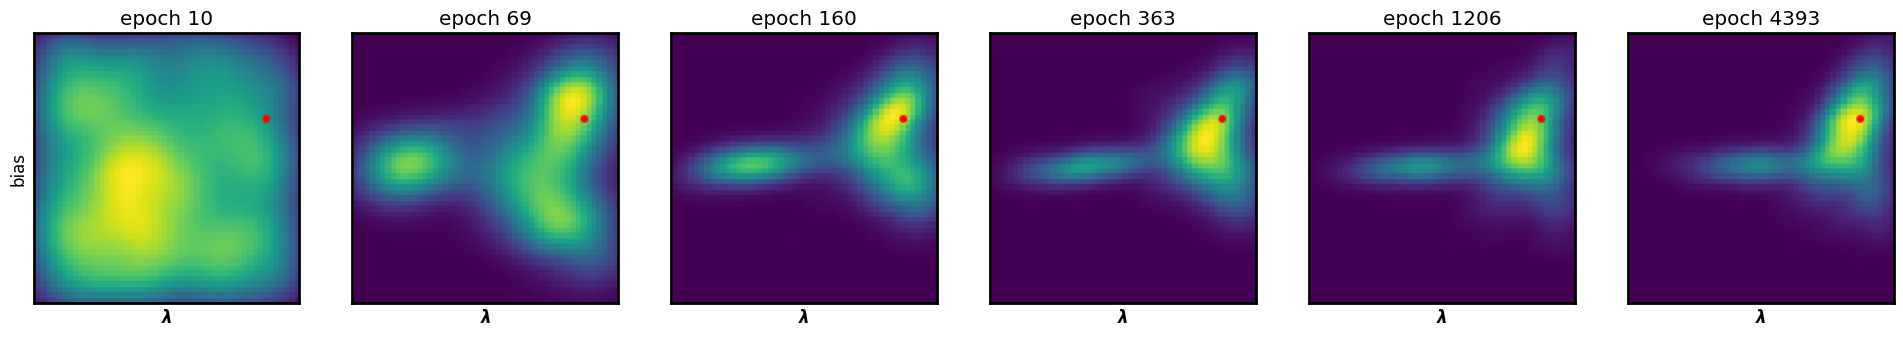

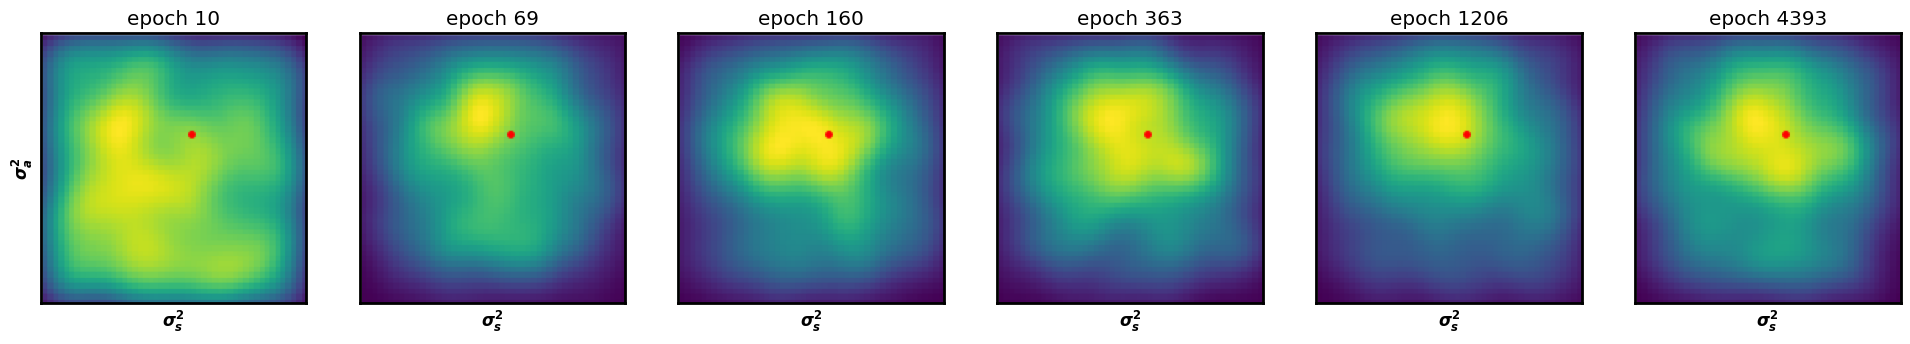

In [14]:
# %% ========== plot posterior training process
num_epoch = 6
best_epoch = step_nums[np.argmax(log_probs_valid)]

# get recorded posterior plot names
img_folder = Path(f"{log_dir}/posterior/figures")
posterior_plots = img_folder.glob("posterior_seen_0*.png")
posterior_idx = [eval(str(plot).split("epoch_")[-1].split(".png")[0]) for plot in posterior_plots]
posterior_idx = np.array(posterior_idx)[np.argsort(posterior_idx)]

chosen_idx = np.linspace(10, len(posterior_idx) - 1, num_epoch, dtype=int)

BL_coor = [731, 731 + 170, 99, 99 + 173]  # x_start, x_end, y_start, y_end
BL_labels = ["$\lambda$", "bias"]
AS_coor = [528, 528 + 170, 304, 304 + 173]  # x_start, x_end, y_start, y_end
AS_labels = ["$\sigma^2_s$", "$\sigma^2_a$"]

coor = BL_coor
labels = BL_labels

# coor = AS_coor
# labels = AS_labels
fig, axes = plt.subplots(1, num_epoch, figsize=(num_epoch * 4, 4))
for i, epoch_idx in enumerate(chosen_idx):
    ax = axes[i]
    img_path = img_folder / f"posterior_seen_0_epoch_{posterior_idx[epoch_idx]}.png"
    if img_path.exists():
        load_img(
            img_path=img_path,
            ax=ax,
            title=f"epoch {posterior_idx[epoch_idx]}",
            crop=True,
            x_start=coor[0],
            x_end=coor[1],
            y_start=coor[2],
            y_end=coor[3],
        )
    ax.set_xlabel(labels[0])
    if i == 0:
        ax.set_ylabel(labels[1])

coor = AS_coor
labels = AS_labels
fig, axes = plt.subplots(1, num_epoch, figsize=(num_epoch * 4, 4))
for i, epoch_idx in enumerate(chosen_idx):
    ax = axes[i]
    img_path = img_folder / f"posterior_seen_0_epoch_{posterior_idx[epoch_idx]}.png"
    if img_path.exists():
        load_img(
            img_path=img_path,
            ax=ax,
            title=f"epoch {posterior_idx[epoch_idx]}",
            crop=True,
            x_start=coor[0],
            x_end=coor[1],
            y_start=coor[2],
            y_end=coor[3],
        )
    ax.set_xlabel(labels[0])
    if i == 0:
        ax.set_ylabel(labels[1])

## Load posterior samples 

In [16]:
# %% ==========  get posterior samples
config, model_path = load_stored_config(exp_dir=log_dir)

if "p4" in pipeline_version:
    from train.train_L0_p4a import Solver
if "p5" in pipeline_version:
    from train.train_L0_p5a import Solver

solver, posterior, train_loader, valid_loader, train_dataset, valid_dataset = get_posterior(
    model_path=model_path,
    config=config,
    device="cuda",
    Solver=Solver,
    low_batch=20,
    return_dataset=True,
)

==>> config_path: /home/wehe/tmp/NSC/codes/src/train/logs/train_L0_p5a/p5a-conv_lstm-corr_conv-tmp-2/config.yaml
using device: cuda

--- CUDA info ---
NVIDIA RTX A6000
Memory Usage:
Allocated: 0.4 GB
Cached:    0.6 GB
--- CUDA info ---

prior min before norm: [-2.5, 0, 0, -11]
prior max before norm: [2.5, 77, 18, 10]
prior min: [0. 0. 0. 0.]
prior max: [1. 1. 1. 1.]

=== embedding net === 
conv_lstm


/home/wehe/anaconda3/envs/sbi/lib/python3.10/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(



=== train, val dataset and dataloader ===
train_set_names=['set_0', 'set_1', 'set_10', 'set_11', 'set_12', 'set_13', 'set_14', 'set_15', 'set_16', 'set_17', 'set_18', 'set_19', 'set_2', 'set_20', 'set_21', 'set_22', 'set_23', 'set_24']
valid_set_names=['set_25', 'set_26']
[training] sets Loading 18 dataset into memory... 
['set_0', 'set_1', 'set_10', 'set_11', 'set_12', 'set_13', 'set_14', 'set_15', 'set_16', 'set_17', 'set_18', 'set_19', 'set_2', 'set_20', 'set_21', 'set_22', 'set_23', 'set_24'] ... 0 2 4 6 8 10 12 14 16  finished in: 1.09s
dur of [3, 9, 15] are chosen, others are [removed] 
[seqC] shape: (18, 3, 3, 700, 15)
[theta] shape: (18, 500, 4)
[probR] shape: (18, 3, 3, 700, 500, 1)
==>> Further Sampling 20 times from probR (given 'in_dataset' process setting) ... in 0.03min
sampled chR shape torch.Size([18, 9, 700, 500, 20, 1]) MEM size 4.22GB, Total samples: 180000 

[validation] sets Loading 2 dataset into memory... 
['set_25', 'set_26'] ... 0  finished in: 0.07s
dur of [3

/home/wehe/anaconda3/envs/sbi/lib/python3.10/site-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


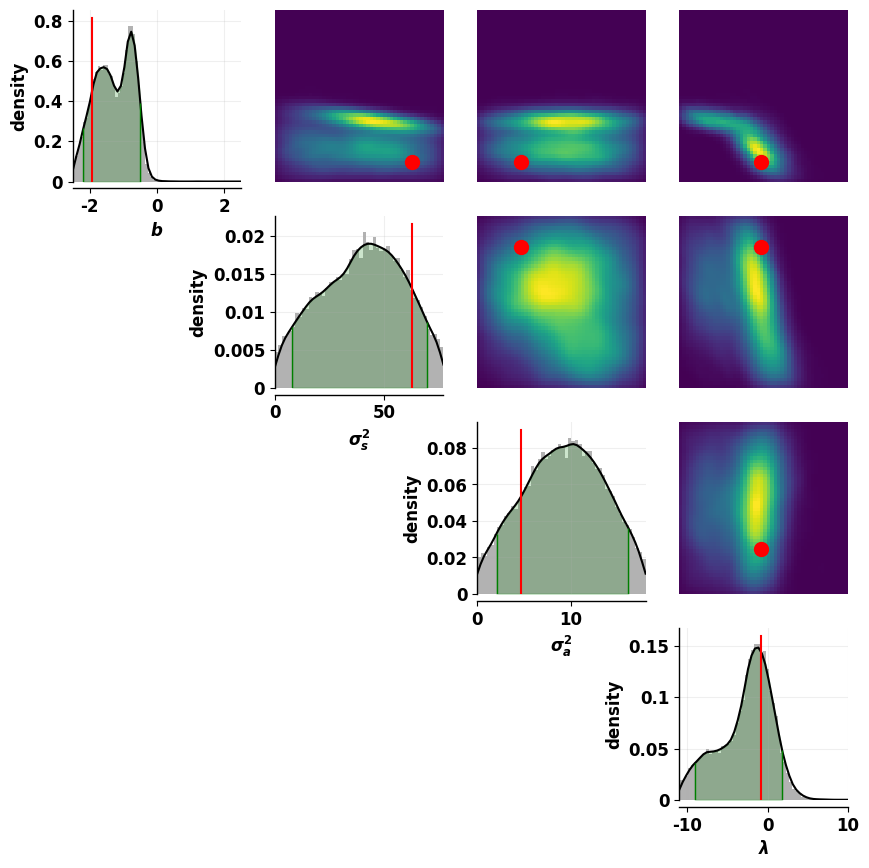

In [75]:
# %% load one sample - training sample
# seen_data = solver.inference.seen_data_for_posterior
# xy_o, true_theta = seen_data["x"][1], seen_data["theta"][1]
xy_o, true_theta = train_dataset[0]

# %%
normed_limits = solver._get_limits()
designed_limits = get_limits(config.prior.prior_min, config.prior.prior_max)

font = {
    "weight": "bold",
    "size": 12,
}
mpl.rc("font", **font)
mpl.rcParams["axes.linewidth"] = 1

fig, ax, samples = plot_posterior_mapped_samples(
    posterior,
    xy_o,
    true_theta=true_theta,
    num_samples=20_000,
    sampling_device="cuda",
    show_progress_bars=False,
    original_limits=normed_limits,
    mapped_limits=designed_limits,
)

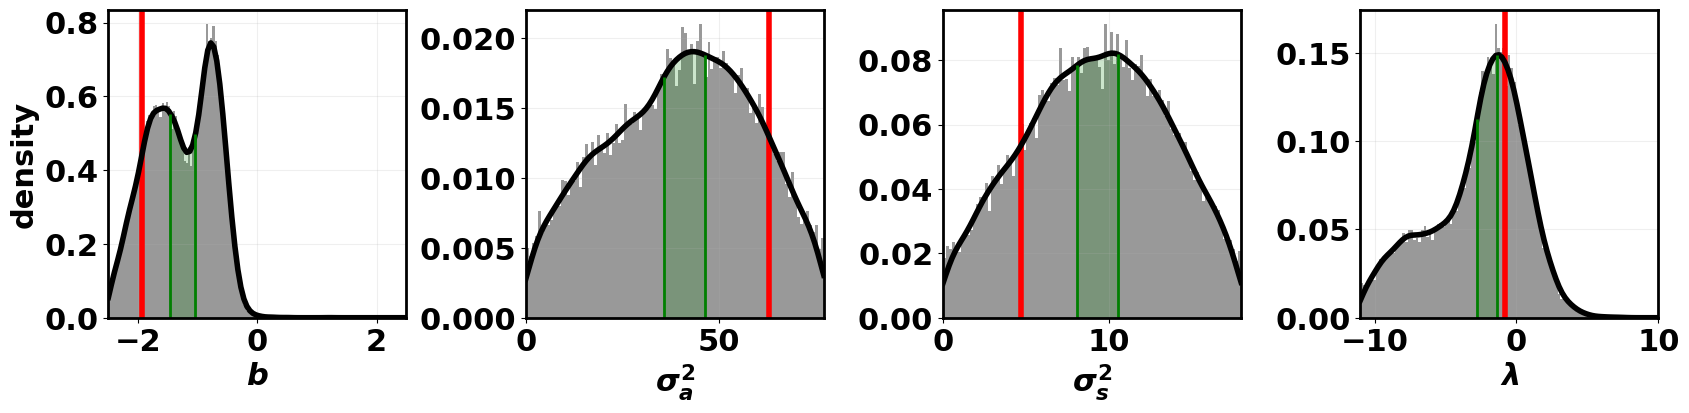

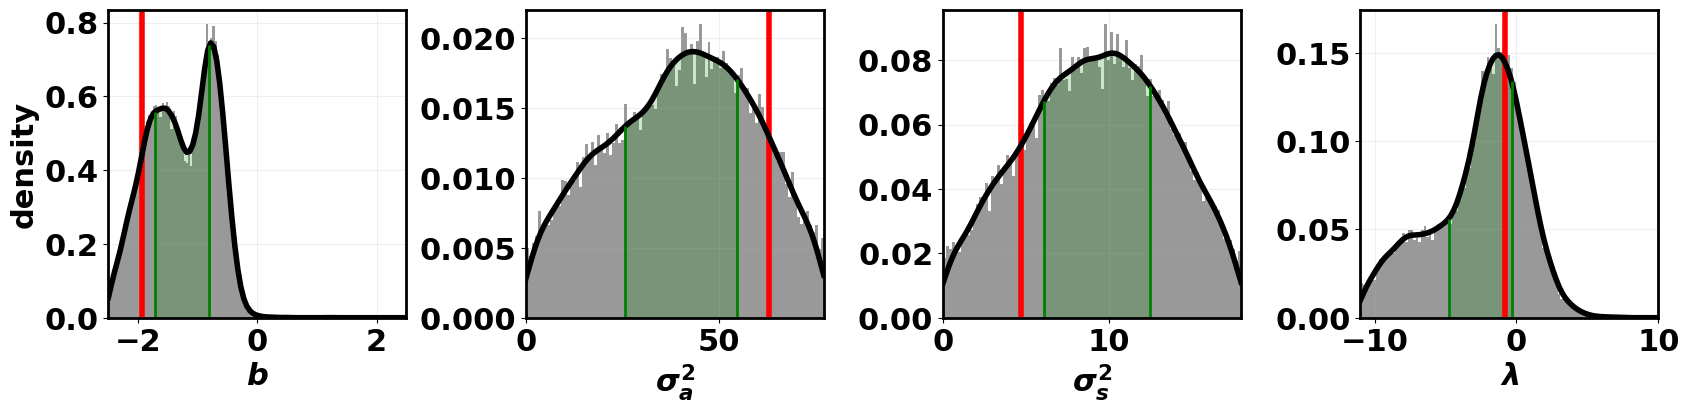

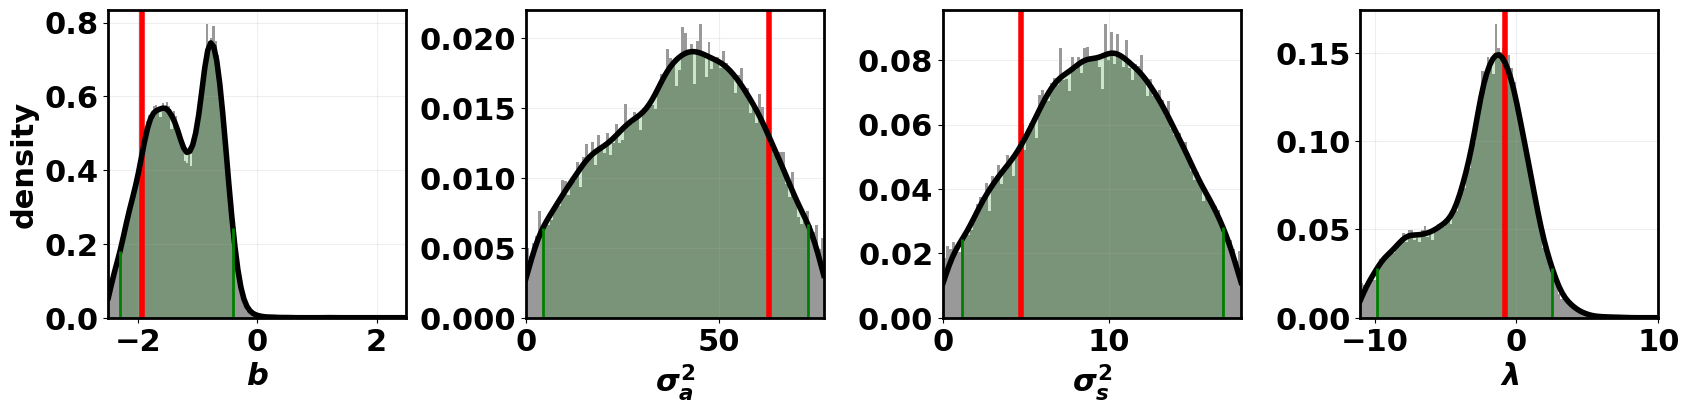

In [77]:
font = {"size": 22}
mpl.rc("font", **font)
# axis line width
mpl.rcParams["axes.linewidth"] = 2

credible_intervals = [20, 50, 95]
for credible_interval in credible_intervals:
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    fig.subplots_adjust(wspace=0.4)
    true_theta_dr = convert_samples_range(true_theta, normed_limits, designed_limits)
    axes = marginal_plot(
        samples,
        true_theta_dr,
        origin_limits=designed_limits,
        dest_limits=designed_limits,
        credible_interval=credible_interval,
        axes=axes,
    )
    for i in range(len(axes)):
        axes[i].set_xlabel(prior_labels[i])

## change one of the parameter and see how the prediction changes

In [53]:
# prepare varying theta values
print(f"{designed_limits=}")
ref_theta_values = [1, 10, 10, 1]

step = 5
theta_values = np.ones((4 * step, 4))
for i in range(len(ref_theta_values)):
    theta_values[:, i] = ref_theta_values[i]

for i, limits in enumerate(designed_limits):
    values = np.linspace(limits[0], limits[1], step)
    theta_values[i * step : (i + 1) * step, i] = values

designed_limits=[[-2.5, 2.5], [0, 77], [0, 18], [-11, 10]]


In [54]:
# prepare varying theta values
print(f"{designed_limits=}")
ref_theta_values = [1, 10, 10, 1]

step = 5
theta_values = np.ones((4 * step, 4))
for i in range(len(ref_theta_values)):
    theta_values[:, i] = ref_theta_values[i]

for i, limits in enumerate(designed_limits):
    values = np.linspace(limits[0], limits[1], step)
    theta_values[i * step : (i + 1) * step, i] = values
# [T, 4] = [5*4, 4]

# prepare the seqC_o
x_o = xy_o[:, :-1]
seqC_o = x2seqC(x_o).unsqueeze(1).unsqueeze(1)
print(f"==>> x_o.shape: {x_o.shape}")
print(f"==>> seqC_o.shape: {seqC_o.shape}")

# run the simulator
params, probR = DM_sim_for_seqCs_parallel_with_smaller_output(
    seqCs=seqC_o,
    prior=theta_values,
    num_workers=16,
    privided_prior=True,
)

# save the results
np.savez(
    f"{log_dir}/posterior/dataset_validation.npz",
    seqC_o=seqC_o,
    theta_values=theta_values,
    params=params,
    probR=probR,
)

designed_limits=[[-2.5, 2.5], [0, 77], [0, 18], [-11, 10]]
==>> x_o.shape: torch.Size([6300, 15])
==>> seqC_o.shape: torch.Size([6300, 1, 1, 15])

--- simulating pR with... ---
prior sample size: 1
model_name: B-G-L0S-O-N-
total number of simulations 126000 with 16 workers ...



/tmp/ipykernel_2523233/3667986402.py:22: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  params, probR = DM_sim_for_seqCs_parallel_with_smaller_output(
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    4.2s
[Parallel(n_jobs=16)]: Done 464 tasks      | elapsed:    4.6s
[Parallel(n_jobs=16)]: Done 4400 tasks      | elapsed:    7.2s
[Parallel(n_jobs=16)]: Done 10000 tasks      | elapsed:   10.7s
[Parallel(n_jobs=16)]: Done 17200 tasks      | elapsed:   15.2s
[Parallel(n_jobs=16)]: Done 26000 tasks      | elapsed:   20.5s
[Parallel(n_jobs=16)]: Done 36400 tasks      | elapsed:   27.0s
[Parallel(n_jobs=16)]: Done 48400 tasks      | elapsed:   34.0s
[Parallel(n_jobs=16)]: Done 62000 tasks      | elapsed:   42.5s
[Parallel(n_jobs=16)]: Done 77200 tasks      | elapsed:   51.8s
[Parallel(n_jobs=16)]: Done 94000 tasks      | elapsed:  

time elapsed for simulation: 1.38 minutes
stacking the results
done stacking the results

seqC.shape: torch.Size([6300, 1, 1, 15]), params.shape: (20, 4), probR.shape: (6300, 1, 1, 20, 1)


[Parallel(n_jobs=16)]: Done 126000 out of 126000 | elapsed:  1.4min finished


In [58]:
# %% load the results
dataset = np.load(f"{log_dir}/posterior/dataset_validation.npz")
seqC_o = dataset["seqC_o"]
theta_values = dataset["theta_values"]
params = dataset["params"]
probR = dataset["probR"]

probR = probR.squeeze(1).squeeze(1)

print(f"==>> seqC_o.shape: {seqC_o.shape}")
print(f"==>> probR.shape: {probR.shape}")

# bernoulli sampling using pytorch
probR = torch.from_numpy(probR).float()
chR = probR.repeat_interleave(10, dim=-1)
chR = torch.bernoulli(chR)
print(f"==>> chR.shape: {chR.shape}")


# %% plot the results
x_o = torch.from_numpy(seqC2x(seqC_o).squeeze(1).squeeze(1))
print(f"==>> x_o.shape: {x_o.shape}")

==>> seqC_o.shape: (6300, 1, 1, 15)
==>> probR.shape: (6300, 20, 1)
==>> chR.shape: torch.Size([6300, 20, 10])
==>> x_o.shape: torch.Size([6300, 15])


In [59]:
xy_o

tensor([[0.5000, 0.3000, 0.3000,  ..., 0.5000, 0.5000, 1.0000],
        [0.5000, 0.5000, 0.9000,  ..., 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.7000,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.5000, 0.5000, 0.6000,  ..., 0.0000, 0.0000, 0.0000],
        [0.5000, 0.3000, 0.7000,  ..., 0.0000, 0.0000, 1.0000],
        [0.5000, 0.5000, 0.7000,  ..., 0.0000, 0.0000, 0.0000]])

theta_test=tensor([0.0000, 0.1299, 0.5556, 0.5714], dtype=torch.float64)


/home/wehe/anaconda3/envs/sbi/lib/python3.10/site-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


theta_test=tensor([0.2500, 0.1299, 0.5556, 0.5714], dtype=torch.float64)


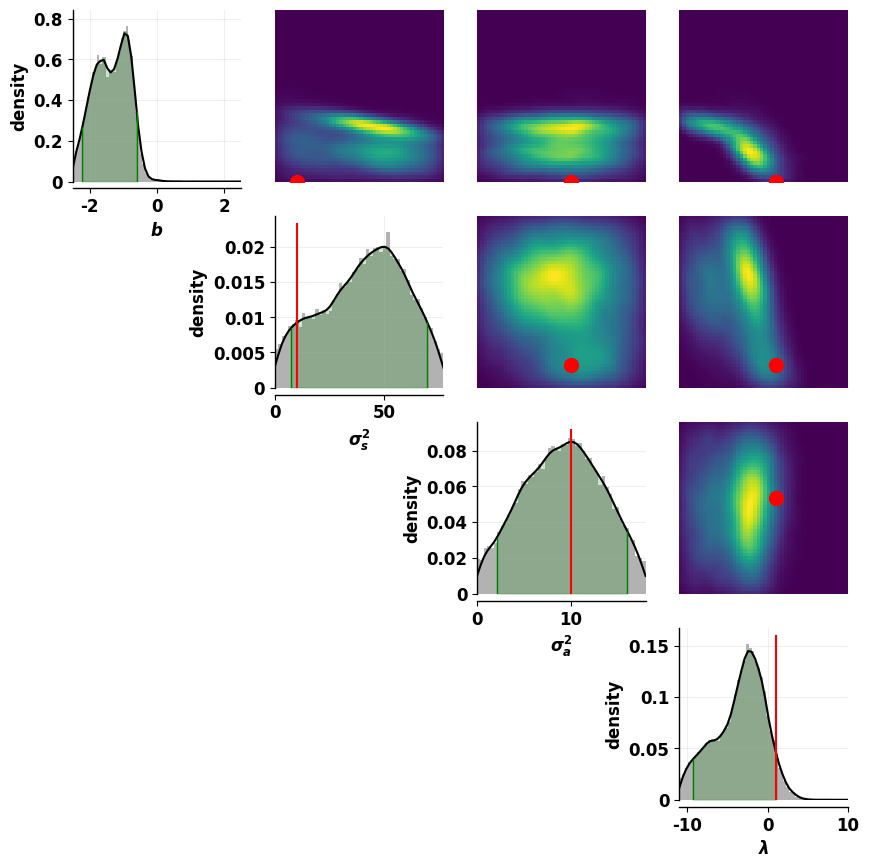

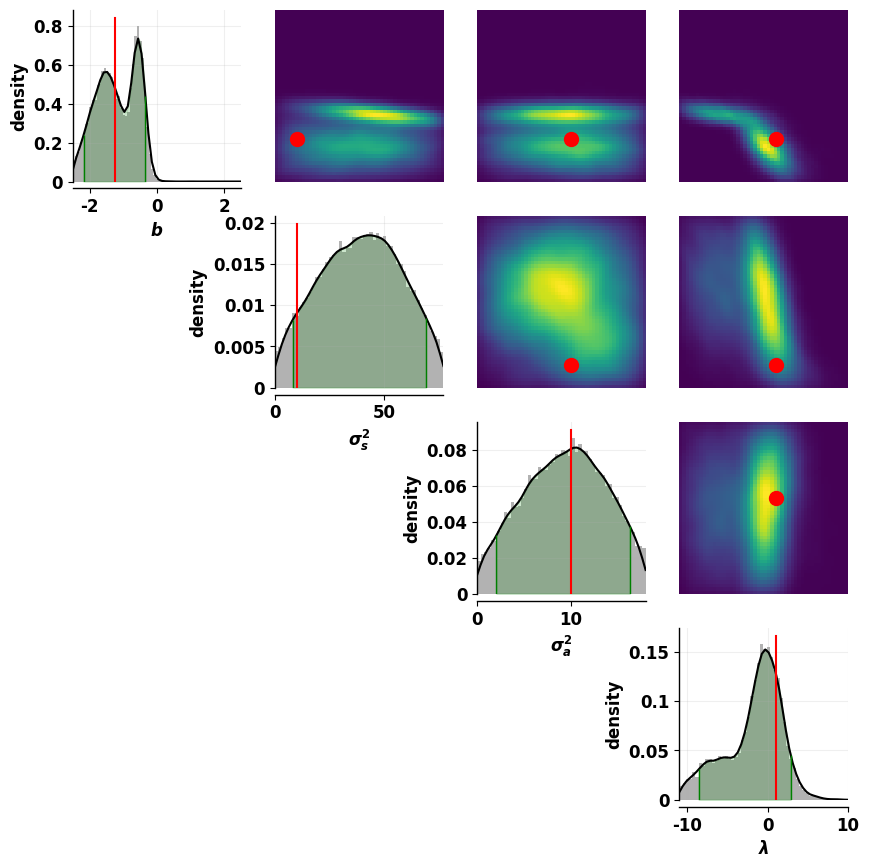

In [60]:
# T = 0
C = 0
# for T in range(20):

for T in range(2):
    theta_test = torch.tensor(theta_values[T, :])
    theta_test = convert_samples_range(theta_test, designed_limits, normed_limits)
    chR_test = chR[:, T, C].unsqueeze(-1)
    xy_test = torch.cat([x_o, chR_test], dim=-1)

    print(f"{theta_test=}")

    plot_posterior_mapped_samples(
        posterior,
        xy_test,
        true_theta=theta_test,
        num_samples=20_000,
        sampling_device="cuda",
        show_progress_bars=False,
        original_limits=normed_limits,
        mapped_limits=designed_limits,
    )

theta_test=tensor([0.2500, 0.1299, 0.5556, 0.5714], dtype=torch.float64)


TypeError: marginal_plot() got an unexpected keyword argument 'prior_labels'

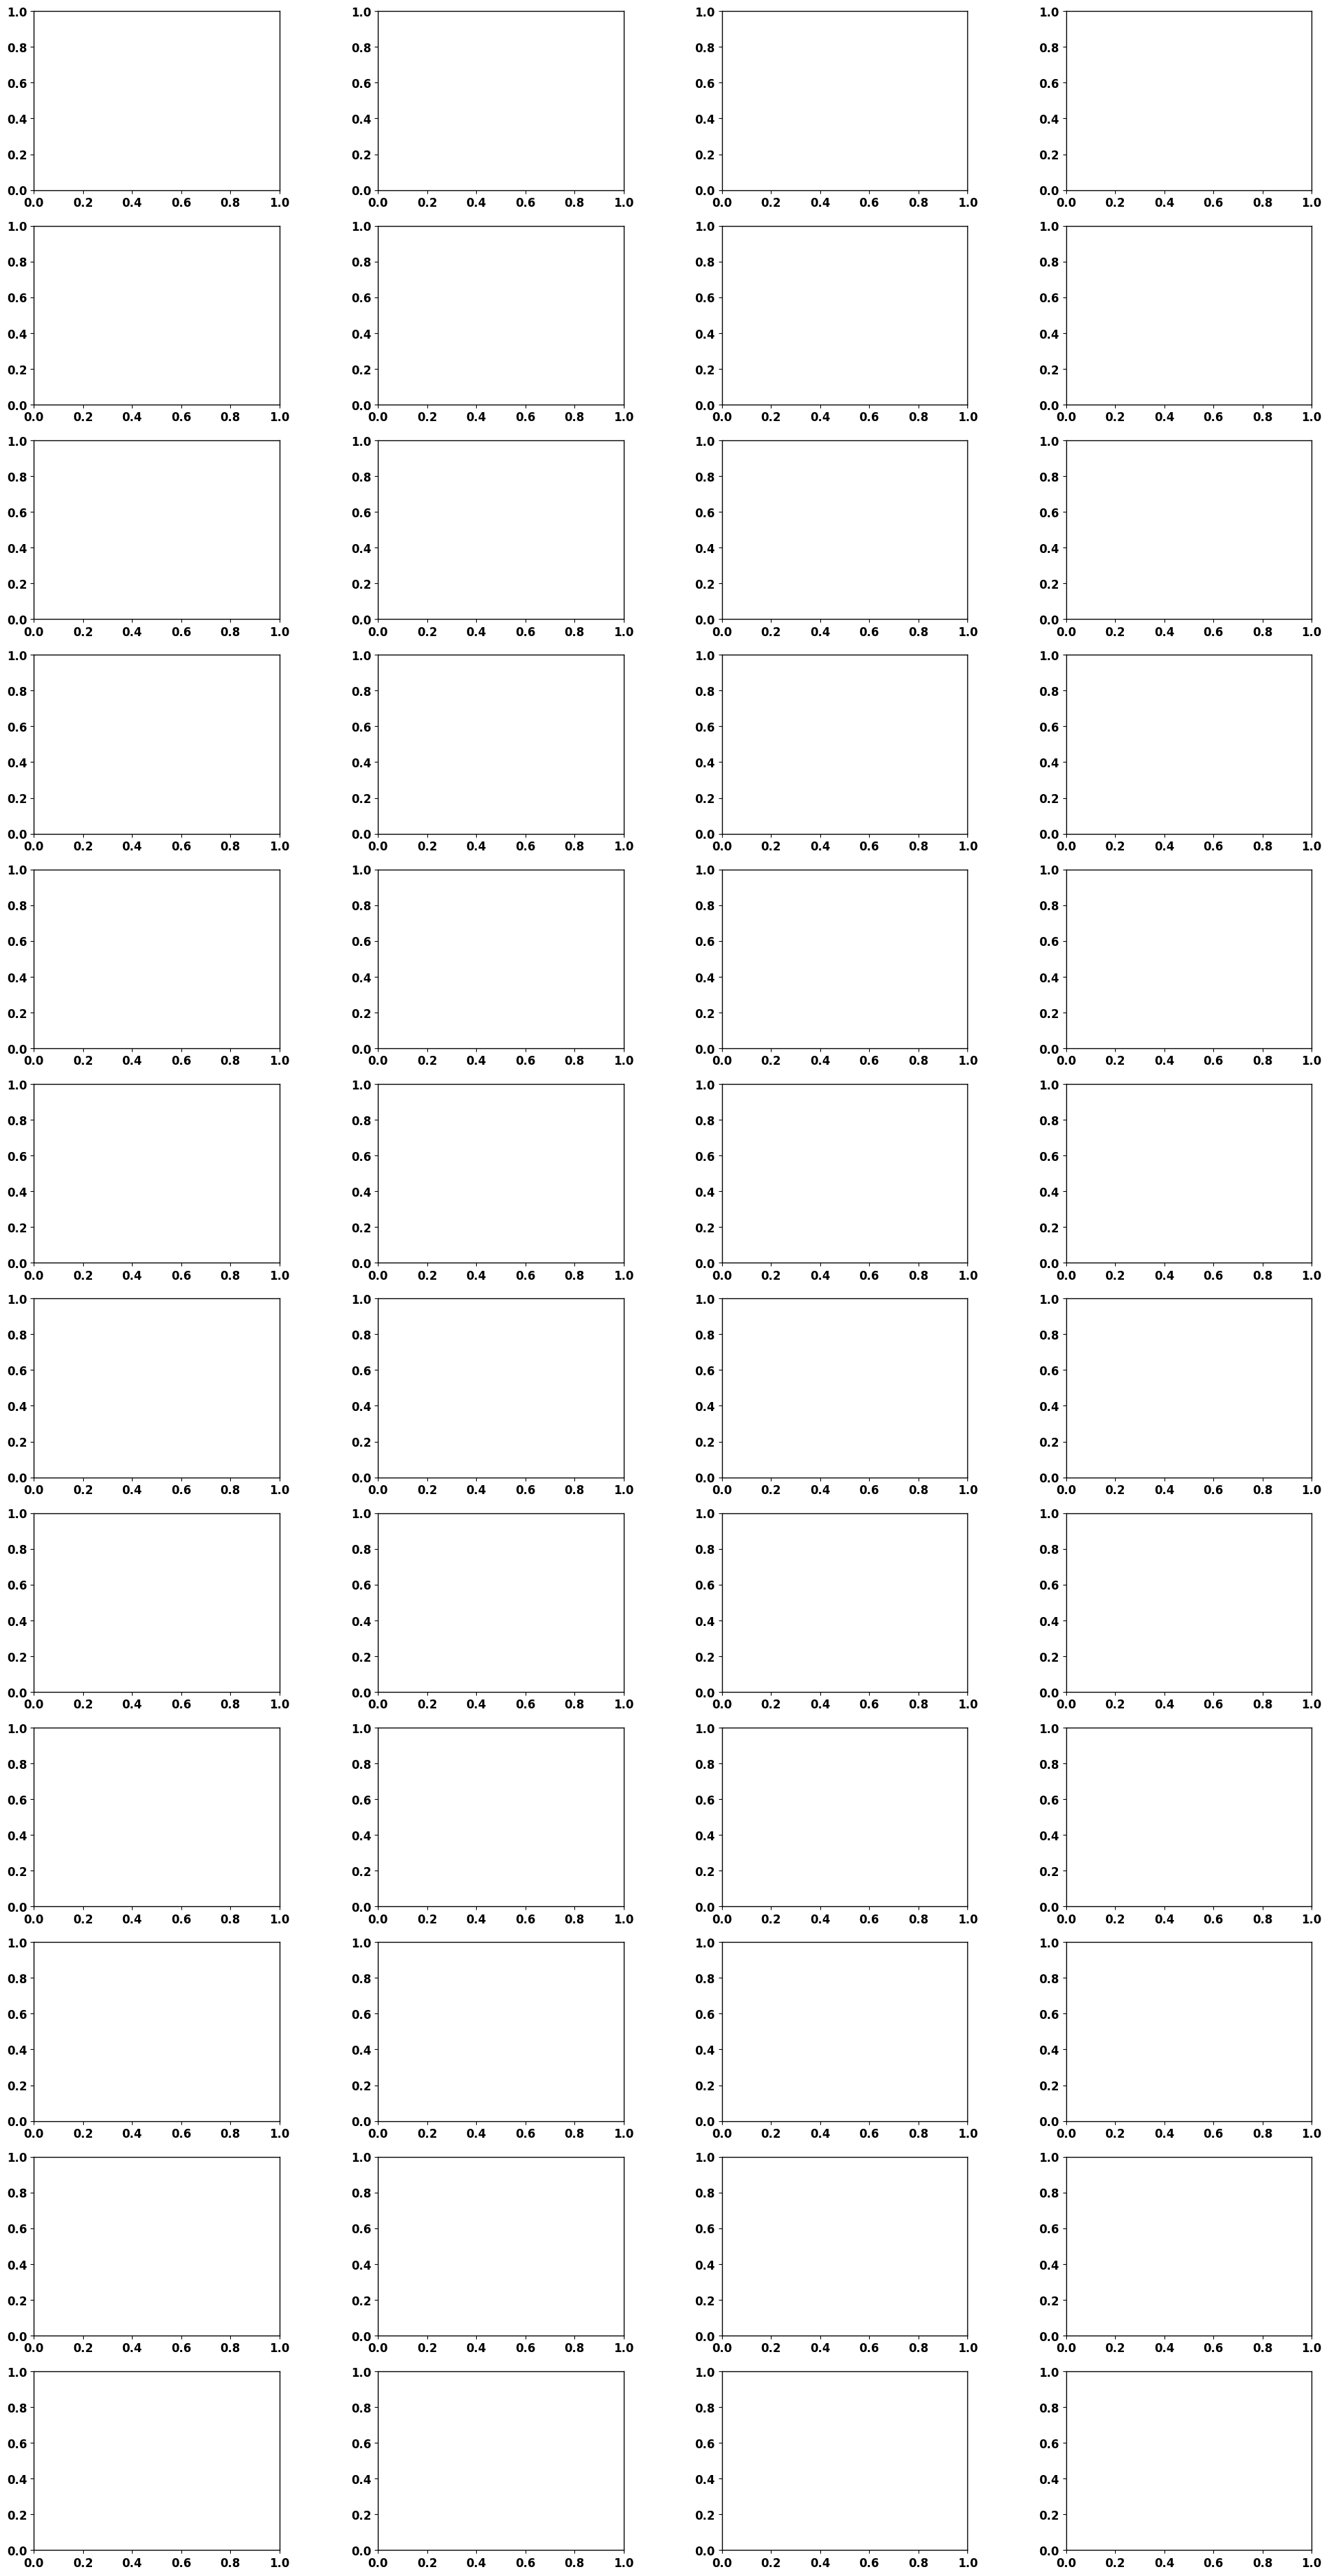

In [61]:
C = 0

num_params = len(prior_labels)
fig, axes = plt.subplots((step - 2) * num_params, 4, figsize=(num_params * 6, 4 * (step - 2) * num_params))

fig.subplots_adjust(wspace=0.4)

counter = 0
for T in range(20):
    if T % step == 0 or T % step == step - 1:
        continue

    moving_theta_idx = T // step

    theta_test = torch.tensor(theta_values[T, :])
    theta_test = convert_samples_range(theta_test, designed_limits, normed_limits)
    chR_test = chR[:, T, C].unsqueeze(-1)
    xy_test = torch.cat([x_o, chR_test], dim=-1)

    print(f"{theta_test=}")

    samples = sampling_from_posterior(
        "cuda",
        posterior,
        xy_test,
        num_samples=20_000,
        show_progress_bars=False,
    )

    ax = marginal_plot(
        samples,
        true_theta=theta_test,
        origin_limits=normed_limits,
        dest_limits=designed_limits,
        prior_labels=prior_labels,
        moving_theta_idx=moving_theta_idx,
        axes=axes[counter, :],
    )
    counter += 1
    if counter == (step - 2) * num_params:
        for x, label in zip(ax, prior_labels):
            x.set_xlabel(label)

merge into a condensed version

In [ ]:
num_params = len(prior_labels)
all_samples = np.zeros((num_params, step - 2, 20_000, 4))
all_thetas = np.zeros((num_params, step - 2, 4))
C = 0
for T in range(20):
    if T % step == 0 or T % step == step - 1:
        continue

    moving_theta_idx = T // step
    trial_idx = T % step - 1

    theta_test = torch.tensor(theta_values[T, :])
    theta_test = convert_samples_range(theta_test, designed_limits, normed_limits)
    chR_test = chR[:, T, C].unsqueeze(-1)
    xy_test = torch.cat([x_o, chR_test], dim=-1)

    samples = sampling_from_posterior(
        "cuda",
        posterior,
        xy_test,
        num_samples=20_000,
        show_progress_bars=False,
    )
    all_samples[moving_theta_idx, trial_idx, :, :] = samples
    all_thetas[moving_theta_idx, trial_idx, :] = theta_test

all_samples_dr = convert_samples_range(all_samples, normed_limits, designed_limits)
all_thetas_dr = convert_samples_range(all_thetas, normed_limits, designed_limits)

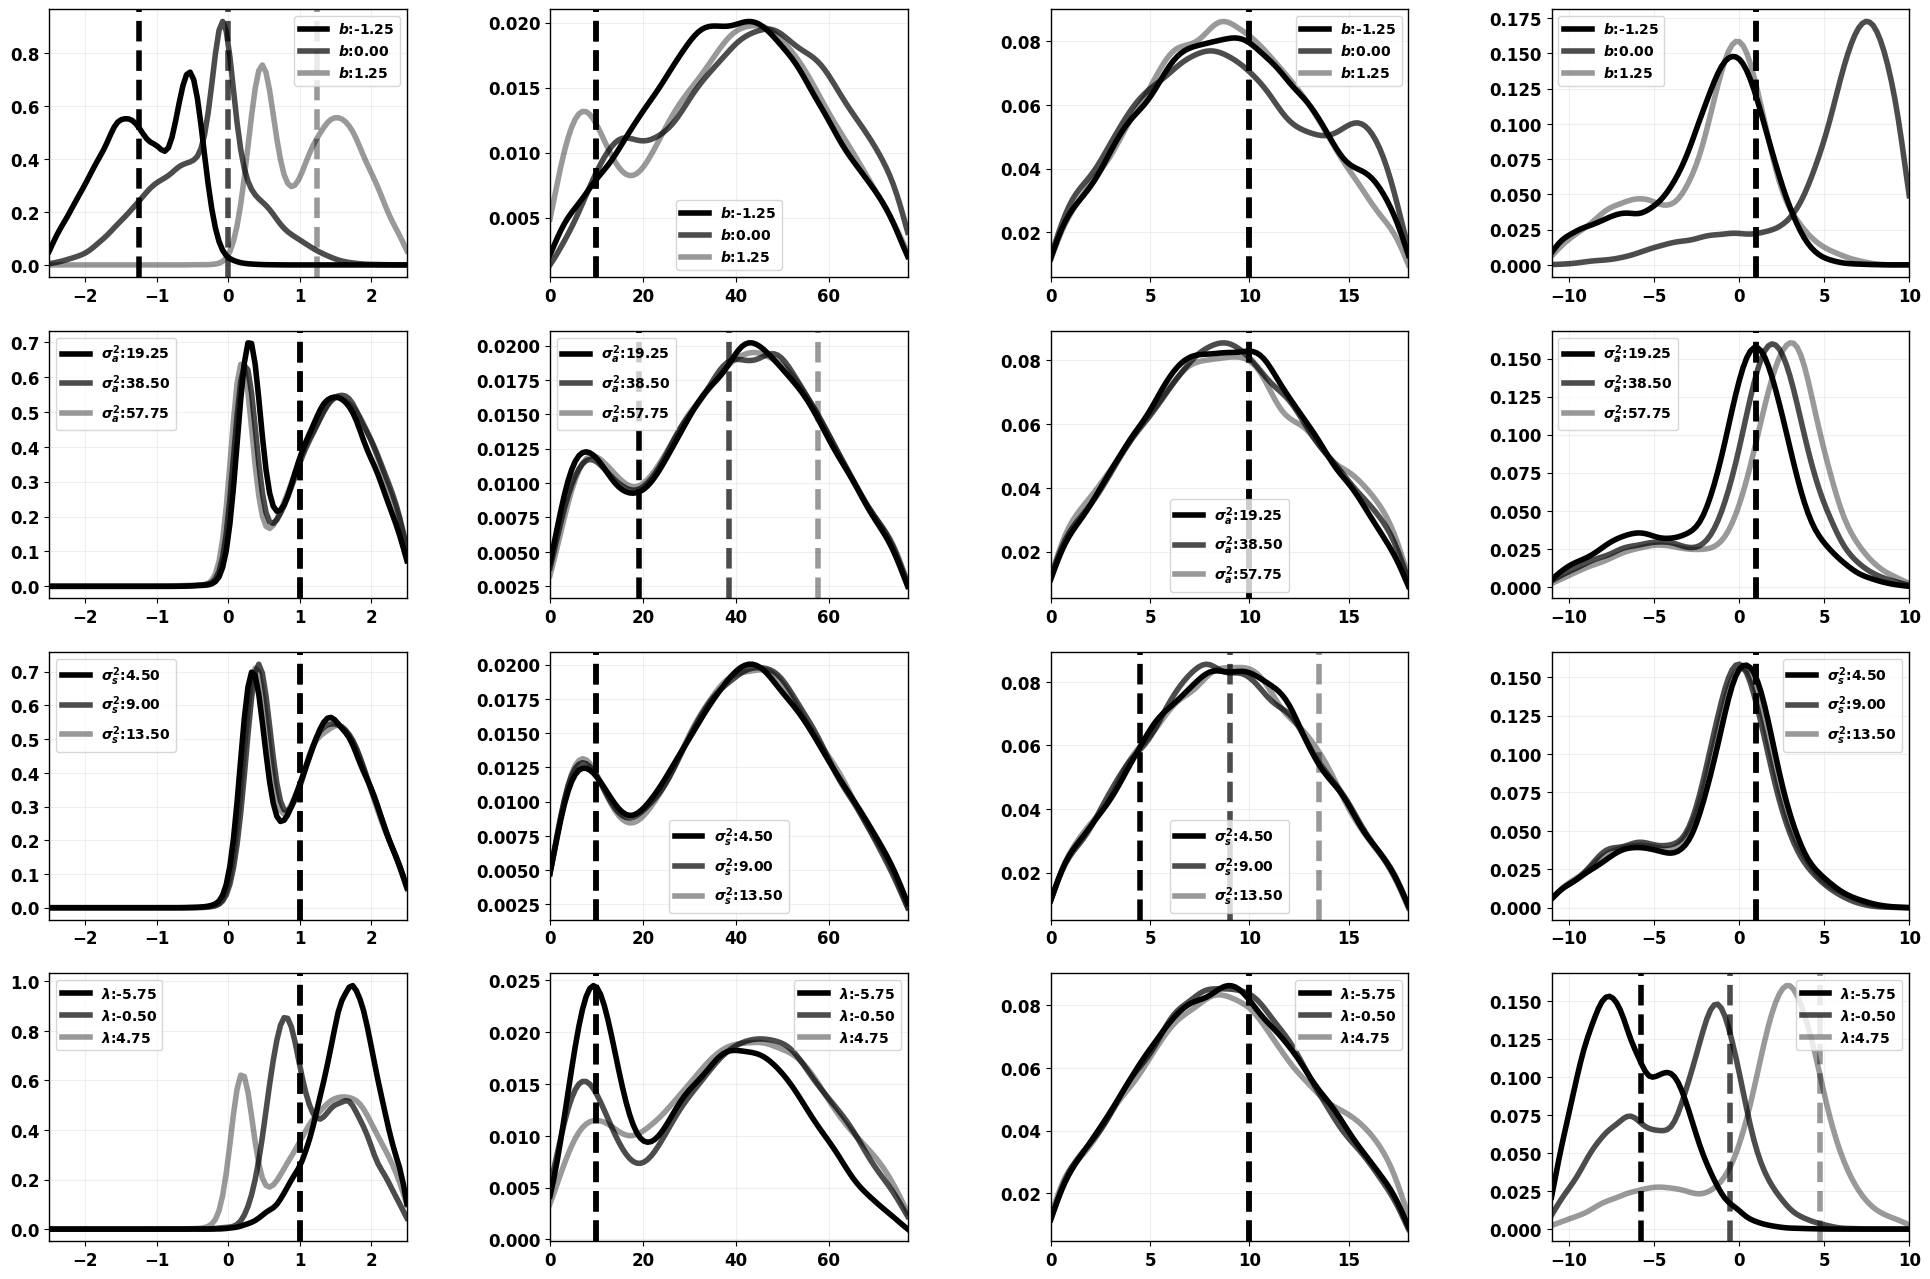

In [ ]:
fig, axes = plt.subplots(
    all_thetas_dr.shape[0],
    all_thetas_dr.shape[-1],
    figsize=(all_thetas_dr.shape[-1] * 6, 4 * all_thetas_dr.shape[0]),
)
fig.subplots_adjust(wspace=0.4)
num_trials = all_thetas_dr.shape[1]

dest_limits = designed_limits

for i in range(all_thetas_dr.shape[0]):
    ax_row = axes[i, :]
    samples_row = all_samples_dr[i]
    moving_theta_idx = i

    for j in range(num_params):
        for k in range(num_trials):
            ax = ax_row[j]
            density = gaussian_kde(samples_row[k, :, j], bw_method="scott")
            xs = np.linspace(dest_limits[j][0], dest_limits[j][1], 100)
            ys = density(xs)
            ax.plot(
                xs,
                ys,
                "k",
                linewidth=4,
                label=f"{prior_labels[i]}:{all_thetas_dr[i, k, i]:.2f}",
                alpha=1 - 0.6 * k / (num_trials - 1),
            )
            ax.set_xlim(dest_limits[j][0], dest_limits[j][1])
            ax.legend(fontsize=10)
            ax.axvline(
                all_thetas_dr[i, k, j],
                color="k",
                linestyle="--",
                linewidth=4,
                alpha=1 - 0.6 * k / (num_trials - 1),
            )
            ax.grid(alpha=0.2)

## evaluate the performance of the trained model
on whole trained dataset </br>
on whole validation dataset </br>

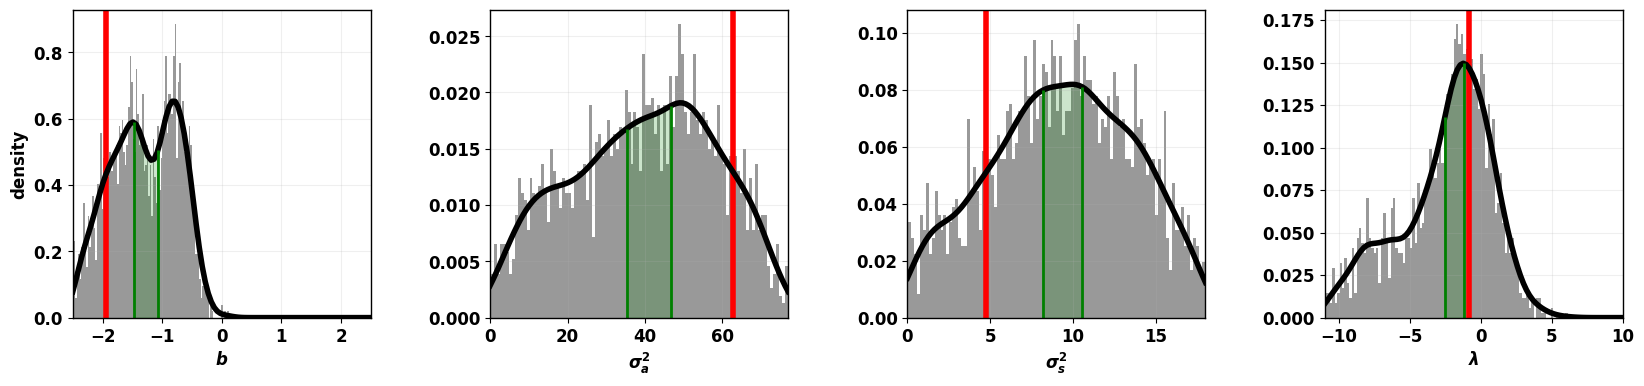

In [62]:
xy, theta = train_dataset[0]

samples = sampling_from_posterior(
    "cuda",
    posterior,
    xy,
    num_samples=2000,
    show_progress_bars=False,
)

fig, axes = plt.subplots(1, 4, figsize=(20, 4))
fig.subplots_adjust(wspace=0.4)
ax = marginal_plot(
    samples,
    theta,
    origin_limits=normed_limits,
    dest_limits=designed_limits,
    moving_theta_idx=-1,
    axes=axes,
    credible_interval=20,
)
for i, x in enumerate(ax):
    x.set_xlabel(prior_labels[i])

check performance on the training dataset

In [63]:
credible_intervals = [20, 50, 95]

ci_valid = ci_perf_on_dset(posterior, credible_intervals, valid_dataset, num_params)
np.save(f"{log_dir}/posterior/ci_valid.npy", ci_valid)
# ci_train = ci_perf_on_dset(posterior, credible_intervals, train_dataset, num_params)

credible interval: 20%


100%|██████████| 20000/20000 [05:42<00:00, 58.45it/s] 


credible interval: 50%


100%|██████████| 20000/20000 [05:35<00:00, 59.67it/s] 


credible interval: 95%


100%|██████████| 20000/20000 [05:37<00:00, 59.32it/s] 


In [79]:
ci_valid

array([[0.1957 , 0.1238 , 0.1465 , 0.15405],
       [0.4664 , 0.37485, 0.3816 , 0.4177 ],
       [0.9156 , 0.88735, 0.8832 , 0.90625]])